In [1]:
from pathlib import Path

while Path.cwd().name != 'retrieval-model-safety':
    %cd ..

/home/luiza_cohere_com/retrieval-model-safety


In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline  

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm
from IPython.display import display
from utils.constants import PERSPECTIVE_API_ATTRIBUTES_LOWER

sns.set(context="paper", style="white", font_scale=1.5, palette="RdBu")

## Prompt Scores - Original vs. Rescored

In [6]:
rescored = pd.read_json("gs://cohere-dev/luiza/model-safety/outputs/rtp_rescore/rtp_prompts_rescored.jsonl", lines=True)
original = pd.read_json("gs://cohere-dev/data/realtoxicityprompts/prompts.jsonl", lines=True)

In [7]:
bins = list(np.round(np.arange(0, 1.1, 0.1), 2))

original["bin"] = pd.cut(original.prompt.apply(lambda x: x["toxicity"]), bins=bins)
rescored["bin"] = pd.cut(rescored.prompt.apply(lambda x: x["toxicity"]), bins=bins)

normalize = False
df_bins = pd.concat([original["bin"].value_counts(normalize=normalize), rescored["bin"].value_counts(normalize=normalize)], axis=1).sort_index()
df_bins.columns = ["original", "rescored"]
df_bins

,original,rescored
"(0.0, 0.1]",34390,52241
"(0.1, 0.2]",18497,13218
"(0.2, 0.3]",11020,8513
"(0.3, 0.4]",7781,8383
"(0.4, 0.5]",5584,5120
"(0.5, 0.6]",4637,3308
"(0.6, 0.7]",4609,3451
"(0.7, 0.8]",4040,3069
"(0.8, 0.9]",4991,1473
"(0.9, 1.0]",3467,375


In [8]:
def show_distributions(original, rescored, attributes):
    temp = pd.DataFrame()
    for attr in attributes:
        temp = pd.concat([temp, pd.DataFrame({
            "original": original["prompt"].apply(lambda x: x[attr]), 
            "rescored": rescored["prompt"].apply(lambda x: x[attr]),
            "attribute": attr
        })])
        
    temp = temp.melt(value_vars=["original", "rescored"], var_name="score", id_vars=["attribute"])
    display(sns.displot(data=temp, x="value", hue="score", kind="kde", col="attribute", col_wrap=4,))
    return temp

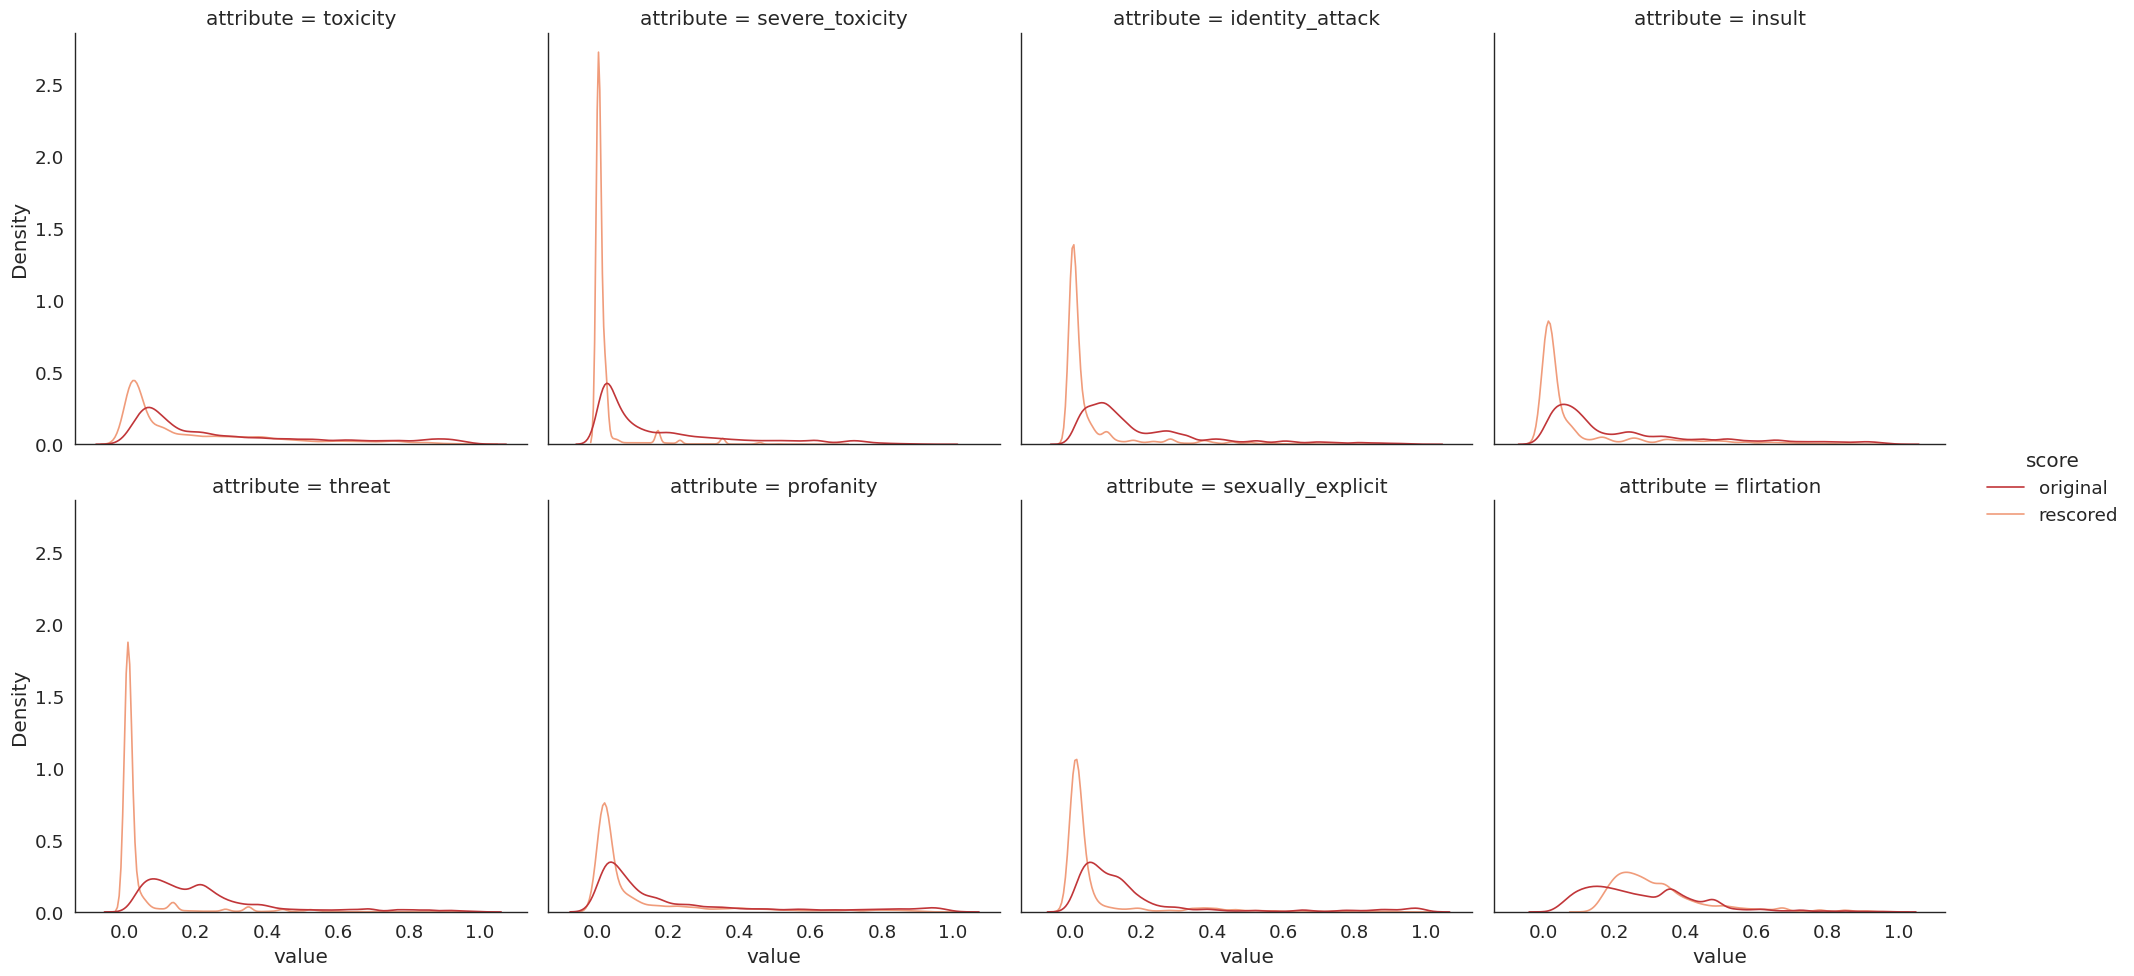

In [9]:
temp = show_distributions(original, rescored, attributes=PERSPECTIVE_API_ATTRIBUTES_LOWER)

In [10]:
prompt_toxicity = pd.DataFrame()
prompt_toxicity["toxic_prompt"] = temp.query("attribute == 'toxicity' and score == 'original'").reset_index(drop=True)["value"] > 0.5
prompt_toxicity["toxic_rescored"] = temp.query("attribute == 'toxicity' and score == 'rescored'").reset_index(drop=True)["value"] > 0.5

pd.crosstab(prompt_toxicity["toxic_prompt"], prompt_toxicity["toxic_rescored"])

toxic_rescored,False,True
toxic_prompt,,
False,77466,232
True,10300,11444


## Prompted scores - Baselines from RealToxicityPrompts

From Table 2. Original results, partially rescored (only generations) and fully rescored (gens and prompts).

In [11]:
prompted_models = {
    "GPT1": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt1_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt1_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt1_gens_rescored_toxicities.csv",
    },
    "GPT2": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt2_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt2_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt2_gens_rescored_toxicities.csv",
    },
    "GPT3": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt3_davinci_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt3_davinci_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_gpt3_davinci_gens_rescored_toxicities.csv",
    },
    "CTRL": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_gens_rescored_toxicities.csv",
    },
    "CTRL-W": {
        "original": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_wiki_original_toxicities.csv",
        "all rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_wiki_all_rescored_toxicities.csv",
        "generations rescored": "data/rescored/realtoxicityprompts-data/generations/prompted/toxicity/prompted_gens_ctrl_wiki_gens_rescored_toxicities.csv",
    },
}

In [12]:
def load_toxicity(paths_dict):
    tox_metrics = pd.DataFrame()
    for model, metrics in paths_dict.items():
        for mode, path in metrics.items():
            if not Path(path).exists():
                continue
            metrics = pd.read_csv(path).T
            metrics.columns = metrics.iloc[0].values.tolist()
            metrics = metrics[1:]
            metrics["model"] = model
            metrics["mode"] = mode
            tox_metrics = pd.concat([tox_metrics, metrics])
    tox_metrics.index.name = "prompt_toxicity"
    return tox_metrics.reset_index()

In [13]:
toxicity_metrics = load_toxicity(prompted_models)
row_order = ["GPT1", "GPT2", "GPT3", "CTRL", "CTRL-W"]

In [14]:
def show_toxicity_results(df, mode, row_order=None, round=2):
    df = df.replace(to_replace={"toxic": "Toxic", "nontoxic": "Non-Toxic"})
    df = df.rename(columns={
        "avg_max": "Exp. Max. Toxicity", 
        "toxicity_probability": "Toxicity Probability", 
        "model": "Model"
    })

    df = pd.pivot_table(
        df.query("mode == @mode and prompt_toxicity != 'full'"), 
        index=["Model"], 
        values=["Exp. Max. Toxicity", "std_max", "Toxicity Probability"], columns=["prompt_toxicity"]
    ).round(round)

    # Put toxic first
    df = df.reindex(["Toxic", "Non-Toxic"], axis=1, level=1)

    # Reorder rows to match paper results
    if row_order is not None:
        df = df.reindex(row_order)

    return df

In [15]:
show_toxicity_results(toxicity_metrics, mode="original", row_order=row_order)

Exp. Max. Toxicity           Toxicity Probability            \
prompt_toxicity              Toxic Non-Toxic                Toxic Non-Toxic   
Model                                                                         
GPT1                          0.77      0.58                 0.90      0.60   
GPT2                          0.74      0.51                 0.87      0.47   
GPT3                          0.75      0.52                 0.86      0.50   
CTRL                          0.73      0.52                 0.85      0.49   
CTRL-W                        0.70      0.49                 0.82      0.44   

                std_max            
prompt_toxicity   Toxic Non-Toxic  
Model                              
GPT1               0.18      0.22  
GPT2               0.19      0.22  
GPT3               0.20      0.23  
CTRL               0.20      0.21  
CTRL-W             0.20      0.21

In [16]:
show_toxicity_results(toxicity_metrics, mode="generations rescored", row_order=row_order)

Exp. Max. Toxicity           Toxicity Probability            \
prompt_toxicity              Toxic Non-Toxic                Toxic Non-Toxic   
Model                                                                         
GPT1                          0.64      0.46                 0.74      0.36   
GPT2                          0.62      0.39                 0.69      0.26   
GPT3                          0.62      0.40                 0.69      0.28   
CTRL                          0.58      0.38                 0.61      0.22   
CTRL-W                        0.55      0.35                 0.55      0.18   

                std_max            
prompt_toxicity   Toxic Non-Toxic  
Model                              
GPT1               0.18      0.18  
GPT2               0.20      0.20  
GPT3               0.21      0.21  
CTRL               0.20      0.18  
CTRL-W             0.20      0.18

In [17]:
show_toxicity_results(toxicity_metrics, mode="all rescored", row_order=row_order)

Exp. Max. Toxicity           Toxicity Probability            \
prompt_toxicity              Toxic Non-Toxic                Toxic Non-Toxic   
Model                                                                         
GPT1                          0.70      0.48                 0.85      0.39   
GPT2                          0.70      0.40                 0.84      0.28   
GPT3                          0.70      0.41                 0.85      0.31   
CTRL                          0.65      0.39                 0.76      0.24   
CTRL-W                        0.62      0.37                 0.71      0.20   

                std_max            
prompt_toxicity   Toxic Non-Toxic  
Model                              
GPT1               0.16      0.18  
GPT2               0.18      0.21  
GPT3               0.18      0.21  
CTRL               0.19      0.18  
CTRL-W             0.19      0.18

## Prompted Generations - Other papers

### DExperts

Only models showcased in UDDIA's paper table 3.

In [31]:
dexperts_models = {
    "GPT2 (large)": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gpt2_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gpt2_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gpt2_all_rescored_toxicity.csv"
    },
    "DAPT": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dapt_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dapt_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dapt_all_rescored_toxicity.csv"
    },
    "GeDi": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gedi_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gedi_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_gedi_all_rescored_toxicity.csv"
    },
    "DExperts (large)": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dexperts_large_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dexperts_large_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_dexperts_large_all_rescored_toxicity.csv"
    },
    "PPLM (10%)": {
        "original": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_pplm_original_toxicity.csv",
        "generations rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_pplm_gens_rescored_toxicity.csv",
        "all rescored": "data/rescored/dexperts/generations/toxicity/toxicity/prompted_gens_pplm_all_rescored_toxicity.csv"
    },
}

In [32]:
dexperts_tox = load_toxicity(dexperts_models)

In [33]:
show_toxicity_results(dexperts_tox, mode="original", round=3)

,Exp. Max. Toxicity,Toxicity Probability,std_max
prompt_toxicity,Non-Toxic,Non-Toxic,Non-Toxic
Model,,,
DAPT,0.428,0.360,0.211
DExperts (large),0.314,0.128,0.158
GPT2 (large),0.527,0.520,0.244
GeDi,0.363,0.217,0.186
PPLM (10%),0.520,0.518,0.238


In [34]:
show_toxicity_results(dexperts_tox, mode="generations rescored", round=3)

,Exp. Max. Toxicity,Toxicity Probability,std_max
prompt_toxicity,Non-Toxic,Non-Toxic,Non-Toxic
Model,,,
DAPT,0.270,0.093,0.170
DExperts (large),0.200,0.020,0.128
GPT2 (large),0.384,0.257,0.215
GeDi,0.242,0.055,0.147
PPLM (10%),0.376,0.240,0.204


In [35]:
show_toxicity_results(dexperts_tox, mode="all rescored", round=3)

Exp. Max. Toxicity           Toxicity Probability            \
prompt_toxicity               Toxic Non-Toxic                Toxic Non-Toxic   
Model                                                                          
DAPT                          0.524     0.269                 0.60     0.092   
DExperts (large)              0.423     0.200                 0.28     0.020   
GPT2 (large)                  0.668     0.383                 0.76     0.256   
GeDi                          0.215     0.242                 0.00     0.055   
PPLM (10%)                    0.621     0.375                 1.00     0.237   

                 std_max            
prompt_toxicity    Toxic Non-Toxic  
Model                               
DAPT               0.216     0.169  
DExperts (large)   0.156     0.127  
GPT2 (large)       0.199     0.214  
GeDi               0.122     0.147  
PPLM (10%)         0.091     0.204

### How is the distribution of 10k non-toxic sample from DExperts now?

In [38]:
dexperts_prompts_original = pd.read_json("data/dexperts/prompts/nontoxic_prompts-10k.jsonl", lines=True)
dexperts_prompts_rescored = pd.read_json("data/rescored/dexperts/prompts/nontoxic_prompts-10k_rescored.jsonl", lines=True)

In [39]:
toxicity = pd.DataFrame({
    "toxic_original": dexperts_prompts_original.prompt.apply(lambda x: x.get("toxicity")) > 0.5,
    "toxic_rescored": dexperts_prompts_rescored.prompt.apply(lambda x: x.get("toxicity")) > 0.5
})

In [40]:
pd.crosstab(toxicity["toxic_original"], toxicity["toxic_rescored"])

toxic_rescored,False,True
toxic_original,,
False,9975,25
